In [65]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [66]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import SelectFromModel
from sklearn.
rf = RandomForestRegressor(n_estimators = 500)

In [67]:
train = pd.read_csv('train_finale.csv', index_col = 'Unnamed: 0')
test = pd.read_csv('test_finale.csv', index_col = 'Unnamed: 0')

In [68]:
#Dropping the unnecessary columns
train = train.drop(['oem','variant', 'model', 'Height', 'Wheel Base'], axis = 1)#height is incorrectly labelled or recorded
test = test.drop(['oem', 'variant', 'model', 'Height', 'Wheel Base'], axis = 1)

In [69]:
#Creating X_train and y_train
X_train = train.drop('listed_price', axis = 1)
y_train = train['listed_price']
X_test = test.drop('listed_price', axis = 1)
y_test = test['listed_price']
y_test

0        950000.0
1        500000.0
2        738000.0
3        660000.0
4        899999.0
          ...    
3770     295000.0
3771     735859.0
3772     245000.0
3773    1249999.0
3774     200000.0
Name: listed_price, Length: 3775, dtype: float64

In [70]:
X = pd.concat([X_train, X_test], axis = 0, ignore_index = True)
y = pd.concat([y_train, y_test], axis = 0, ignore_index = True)

In [71]:
catcols = [col for col in X_train if X_train[col].dtype == 'O']
catvals = [X_train[col].nunique() for col in catcols]
katie = pd.DataFrame({'catcols': catcols, 'Uniques' : catvals})
katie

,catcols,Uniques
0,transmission,2
1,fuel,5
2,Valve Configuration,5
3,Drive Type,4
4,owner_type,6
5,Fuel Supply System,10
6,body,11
7,Gear Box,11
8,Steering Type,2
9,Front Brake Type,5


In [72]:
#Adding avg_measure to the dataset
X_train['avg_measure'] = (X_train['Length'] + X_train['Width']) / 2
X_test['avg_measure'] = (X_test['Length'] + X_test['Width']) / 2

In [73]:
#Defining features
features = ['top_features',
 'comfort_features',
 'interior_features',
 'exterior_features',
 'safety_features']
X_test['Features'] = np.sum(X_test[features], axis = 1)
X_train['Features'] = np.sum(X_train[features], axis = 1)

In [74]:
#Valves featur
X_train['Valves'] = X_train['No of Cylinder'] * X_train['Valves per Cylinder']
X_test['Valves'] = X_test['No of Cylinder'] * X_test['Valves per Cylinder']


In [75]:
#Tread Features
X_train['Tread'] = (X_train['Front Tread'] + X_train['Rear Tread'])/ 2
X_test['Tread'] = (X_test['Front Tread'] + X_test['Rear Tread'])/ 2

In [76]:
to_drop = ['top_features', 'No of Cylinder', 'Valves per Cylinder',
       'comfort_features', 'interior_features', 'exterior_features',
       'safety_features','Length', 'Width', 'Front Tread', 'Rear Tread']

In [77]:
#Dropping the columns
X_train = X_train.drop(to_drop, axis = 1)
X_test = X_test.drop(to_drop, axis = 1)

/tmp/ipykernel_5929/2297988071.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_mat = pd.concat([X_train, y_train], axis = 1).corr()


<Axes: >

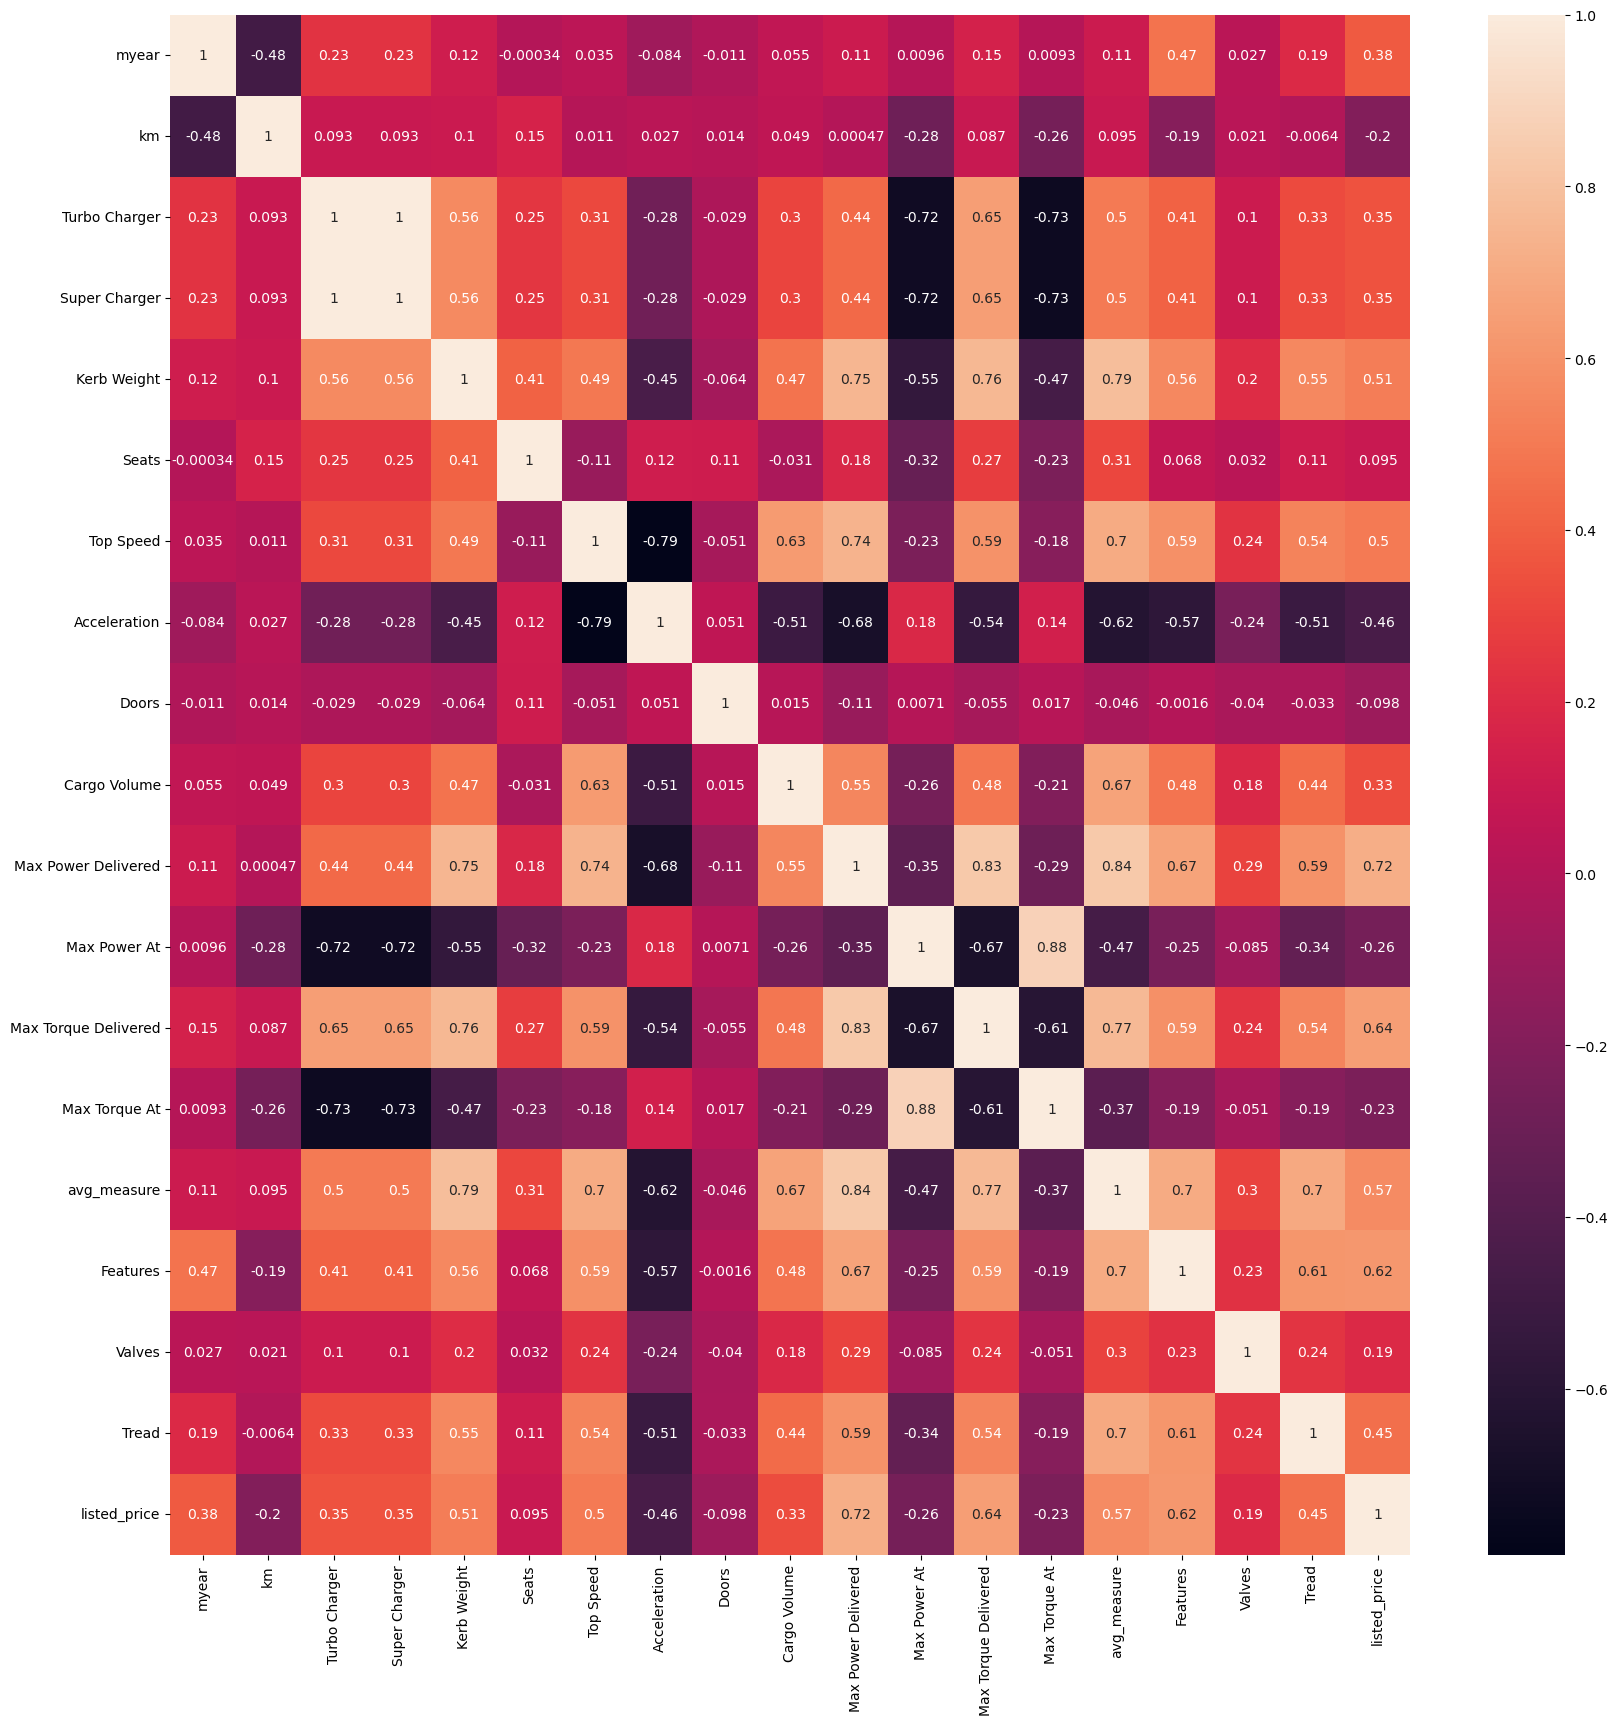

In [78]:
plt.figure(figsize = (20, 20))
corr_mat = pd.concat([X_train, y_train], axis = 1).corr()
sns.heatmap(data = corr_mat, annot = True)

**REPORT:**
- Acceleration and Top Speed high negative correlation

In [79]:
X_train.columns

Index(['myear', 'transmission', 'fuel', 'km', 'Valve Configuration',
       'Turbo Charger', 'Super Charger', 'Kerb Weight', 'Drive Type', 'Seats',
       'Top Speed', 'Acceleration', 'Doors', 'Cargo Volume', 'owner_type',
       'Fuel Supply System', 'Max Power Delivered', 'Max Power At',
       'Max Torque Delivered', 'Max Torque At', 'body', 'Gear Box',
       'Steering Type', 'Front Brake Type', 'Rear Brake Type', 'Tyre Type',
       'exterior_color', 'avg_measure', 'Features', 'Valves', 'Tread'],
      dtype='object')

In [80]:
highly_corr = ['Super Charger', 'Max Power Delivered', 'Max Power At', 'Max Torque At', 'Top Speed']
X_train = X_train.drop(highly_corr, axis = 1)
X_test = X_test.drop(highly_corr, axis = 1)

In [81]:
lcat = [col for col in X_train.columns if X_train[col].dtype == 'O']
num_cols = [col for col in X_train.columns if col not in lcat]

In [82]:
%%time
rf.fit(X_train[num_cols], y_train)
preds = rf.predict(X_test[num_cols])
score = mean_absolute_error(y_test, preds)
score_percent = score * 100 / y_test.mean()
print("MAE: ", score)
print("MAE percent: ", score_percent)

MAE:  104102.92775515968
MAE percent:  13.157102742771192
CPU times: user 46.4 s, sys: 360 ms, total: 46.8 s
Wall time: 46.8 s


In [83]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown = 'ignore', sparse = False)
tra = pd.DataFrame(enc.fit_transform(X_train[lcat]))
tes = pd.DataFrame(enc.transform(X_test[lcat]))

/home/apsit/nayasaap/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [84]:
#Setting index
tra.index = X_train.index
tes.index = X_test.index

In [85]:
#Dropping the categorical columns
X_train = X_train.drop(lcat, axis = 1)
X_test = X_test.drop(lcat, axis = 1)

In [86]:
#Combining the columns back again
X_train = pd.concat([X_train, tra], axis = 1)
X_test = pd.concat([X_test, tes], axis = 1)

In [87]:
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

In [88]:
def mae_percent(y_true, y_preds):
    mae = mean_absolute_error(y_true, y_preds)
    return mae * 100 / y_true.mean()

In [89]:
%%time
rf.fit(X_train, y_train)
preds = rf.predict(X_test)
score = mean_absolute_error(y_test, preds)
score_percent = score * 100 / y_test.mean()
print("MAE: ", score)
print("MAE percent: ", score_percent)

MAE:  100146.52617001577
MAE percent:  12.657070867876863
CPU times: user 1min 30s, sys: 12.2 ms, total: 1min 30s
Wall time: 1min 30s


In [93]:
X_train.shape

(33774, 95)

In [90]:
sel = SelectFromModel(rf)
sel.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestRegressor(n_estimators=500))

In [91]:
sel_features = X_train.columns[(sel.get_support())]
print(sel_features)

Index(['myear', 'km', 'Acceleration', 'Max Torque Delivered', 'avg_measure',
       'Features', 'Tread'],
      dtype='object')


In [92]:
%%time
rf.fit(X_train[sel_features], y_train)
preds = rf.predict(X_test[sel_features])
score = mean_absolute_error(y_test, preds)
score_percent = score * 100 / y_test.mean()
print("MAE: ", score)
print("MAE percent: ", score_percent)

MAE:  105804.40538446272
MAE percent:  13.372144879106855
CPU times: user 36.3 s, sys: 28 ms, total: 36.3 s
Wall time: 36.3 s


In [ ]:
X_train.head(5)

In [ ]:
cols = ['myear','transmission', 'fuel', 'km', 'Turbo Charger', 'Super Charger', 'owner_type', 'listed_price']

In [41]:
from sklearn.

myear                     int64
transmission             object
fuel                     object
km                      float64
top_features            float64
comfort_features        float64
interior_features       float64
exterior_features       float64
safety_features         float64
No of Cylinder          float64
Valves per Cylinder     float64
Valve Configuration      object
Turbo Charger              bool
Super Charger              bool
Length                  float64
Width                   float64
Front Tread             float64
Rear Tread              float64
Kerb Weight             float64
Drive Type               object
Seats                   float64
Top Speed               float64
Acceleration            float64
Doors                   float64
Cargo Volume            float64
owner_type               object
Fuel Supply System       object
Max Power Delivered     float64
Max Power At            float64
Max Torque Delivered    float64
Max Torque At           float64
body    

In [67]:
train.describe()

,myear,km,top_features,comfort_features,interior_features,exterior_features,safety_features,No of Cylinder,Valves per Cylinder,Length,...,Seats,Top Speed,Acceleration,Doors,Cargo Volume,Max Power Delivered,Max Power At,Max Torque Delivered,Max Torque At,listed_price
count,33776.000000,3.377600e+04,33776.000000,33776.000000,33776.000000,33776.000000,33776.000000,33776.000000,33776.000000,33776.000000,...,33776.000000,33776.000000,33776.000000,33776.000000,33776.000000,33776.000000,33776.000000,33776.000000,33776.000000,3.377600e+04
mean,2015.578636,6.222497e+04,8.817383,15.090182,10.070956,10.060648,21.709257,3.816520,3.892942,4112.195622,...,5.235278,172.132739,13.134293,3.997572,355.218984,102.443167,5106.307386,178.422312,3164.192418,7.885685e+05
std,3.774640,5.498804e+04,0.483514,6.072644,2.345593,4.576099,6.926763,0.529434,0.484248,396.582743,...,0.715694,22.300961,2.746565,0.069640,124.663481,41.611622,1029.032339,105.357034,997.067428,3.130544e+06
min,1983.000000,1.010000e+02,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3099.000000,...,0.000000,80.000000,4.100000,2.000000,29.000000,25.400000,1620.000000,4.800000,160.000000,1.196300e+04
25%,2013.000000,3.175550e+04,9.000000,10.000000,9.000000,6.000000,17.000000,4.000000,4.000000,3795.000000,...,5.000000,157.471212,11.546351,4.000000,255.150511,75.000000,4000.000000,110.000000,2125.000000,3.200000e+05
50%,2016.000000,5.652050e+04,9.000000,15.000000,10.000000,10.000000,22.000000,4.000000,4.000000,3995.000000,...,5.000000,170.000000,12.900000,4.000000,346.000000,88.500000,5500.000000,146.000000,3300.000000,5.250000e+05
75%,2018.000000,8.302825e+04,9.000000,19.000000,12.000000,13.000000,27.000000,4.000000,4.000000,4440.000000,...,5.000000,185.000000,14.604886,4.000000,460.000000,118.350000,6000.000000,220.000000,4000.000000,8.537690e+05
max,2023.000000,6.300000e+06,9.000000,39.000000,19.000000,27.000000,49.000000,16.000000,48.000000,5469.000000,...,13.000000,285.000000,44.040000,4.000000,2055.000000,550.000000,7000.000000,850.000000,21800.000000,5.500006e+08


In [68]:
train['myear'].value_counts()

2017    3507
2018    3246
2014    3113
2015    3107
2016    3069
2019    2657
2013    2359
2021    2248
2020    2080
2012    1873
2011    1689
2010    1467
2022    1150
2009    1092
2008     608
2007     177
2006     105
2005      68
2004      48
2023      31
2003      26
2002      21
2001      11
2000      10
1999       4
1997       2
1996       2
1986       1
1983       1
1990       1
1998       1
1993       1
1994       1
Name: myear, dtype: int64